In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import os
from pathlib import Path
import pickle
import timeit
#
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models
from dotted_dict import DottedDict
from tqdm import tqdm
import pprint
#
from csprites.datasets import ClassificationDataset
import utils
from backbone import get_backbone
from optimizer import get_optimizer

In [4]:
class Net(nn.Module):
    def __init__(self, n_classes, d_in, d_hid=1024, n_hid=0):
        super(Net, self).__init__()
        dims = [d_in]
        for _ in range(n_hid):
            dims.append(d_hid)
        dims.append(n_classes)
        #
        layers = []
        for idx in range(1, len(dims) - 1, 1):
            layers.append(nn.Linear(dims[idx - 1], dims[idx]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

def get_datasets(target_idx):
    #
    R_train = torch.Tensor(np.load(p_experiments / experiment_config["p_R_train"]))
    R_valid = torch.Tensor(np.load(p_experiment / experiment_config["p_R_valid"]))
    #
    Y_train = torch.LongTensor(np.load(p_experiment / experiment_config["p_Y_train"]))
    Y_valid = torch.LongTensor(np.load(p_experiment / experiment_config["p_Y_valid"]))
    #
    d_r = R_train.shape[1]
    #
    Y_train = Y_train[:, target_idx]
    Y_valid = Y_valid[:, target_idx]
    #
    ds_train = torch.utils.data.TensorDataset(R_train, Y_train)
    ds_valid = torch.utils.data.TensorDataset(R_valid, Y_valid)

    dl_train = DataLoader(
        ds_train,
        batch_size=linprob_config.batch_size,
        pin_memory=True,
        shuffle=True)
    dl_valid = DataLoader(
        ds_valid,
        batch_size=linprob_config.batch_size,
        pin_memory=True,
        shuffle=True)
    return dl_train, dl_valid, d_r

def train_model(model, num_epochs, optimizer, criterion):
    stats = {
    'train': {
        'loss': [],
        'acc': [],
        'epoch': [],
    },
    'valid': {
        'loss': [],
        'acc': [],
        'epoch': [],
    }
    }
    stats = DottedDict(stats)
    desc_tmp = "Epoch [{:3}/{:3}] {}:"
    #
    for epoch_idx in range(1, num_epochs + 1, 1):
        ################
        # TRAIN
        ################
        model.train()
        epoch_step = 0
        epoch_loss = 0
        epoch_total = 0
        epoch_correct = 0
        #
        desc = desc_tmp.format(epoch_idx, num_epochs, 'train')
        pbar = tqdm(dl_train, bar_format= desc + '{bar:10}{r_bar}{bar:-10b}')
        #
        for x, y in pbar:
            x = x.to(device)
            y = y.to(device)
            for param in model.parameters():
                param.grad = None
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            #
            _, y_pred = torch.max(out, 1)
            total = y.size(0)
            correct = (y_pred == y).sum().item()
            #
            epoch_loss += loss.item()
            epoch_total += total
            epoch_correct += correct
            epoch_step += 1
            #
            pbar.set_postfix({'loss': loss.item(), 'acc': correct / total})
        stats.train.loss.append(epoch_loss / epoch_step)
        stats.train.acc.append(epoch_correct / epoch_total)
        stats.train.epoch.append(epoch_idx)

        ################
        # EVAL
        ################
        model.eval()
        epoch_step = 0
        epoch_loss = 0
        epoch_total = 0
        epoch_correct = 0
        #
        desc = desc_tmp.format(epoch_idx, num_epochs, 'valid')
        pbar = tqdm(dl_valid, bar_format= desc + '{bar:10}{r_bar}{bar:-10b}')
        #
        for x, y in pbar:
            x = x.to(device)
            y = y.to(device)
            with torch.no_grad():
                out = model(x)
                loss = criterion(out, y)
            #
            _, y_pred = torch.max(out, 1)
            total = y.size(0)
            correct = (y_pred == y).sum().item()
            #
            epoch_loss += loss.item()
            epoch_total += total
            epoch_correct += correct
            epoch_step += 1
            #
            pbar.set_postfix({'loss': loss.item(), 'acc': correct / total})
            #
        stats.valid.loss.append(epoch_loss / epoch_step)
        stats.valid.acc.append(epoch_correct / epoch_total)
        stats.valid.epoch.append(epoch_idx)
    return stats

# Settings

In [5]:
# linprob config
linprob_config = {
    'p_eval': '../data/eval',
    'p_eval_results': 'results.pkl',
    'p_config': "linprob_config.pkl",
    'p_results': 'results.pkl',
    'device': "cuda",
    'cuda_visible_devices': '0',
    'n_hid': 0,
    'd_hid': 1024,
    'batch_size': 1024,
    'optimizer': 'adam',
    'optimizer_args': {'lr': 0.001, 'weight_decay': 1e-6},
    'num_epochs': 20,
}
linprob_config = DottedDict(linprob_config)

In [6]:
# TORCH SETTINGS
torch.backends.cudnn.benchmark = True
os.environ["CUDA_VISIBLE_DEVICES"] = linprob_config.cuda_visible_devices
device = torch.device(linprob_config.device)

In [7]:
p_experiements_base = Path("/mnt/experiments/csprites/single_csprites_64x64_n7_c16_a16_p8_s4_bg_inf_random_function_458752")
p_experiments = [
    p_experiements_base / 'bb_[ResNet-18]_target_[shape]',
    p_experiements_base / 'bb_[ResNet-18]_target_[scale]',
    p_experiements_base / 'bb_[ResNet-18]_target_[color]',
    p_experiements_base / 'bb_[ResNet-18]_target_[angle]',
    p_experiements_base / 'bb_[ResNet-18]_target_[py]',
    p_experiements_base / 'bb_[ResNet-18]_target_[px]',
]

bb_[ResNet-18]_target_[shape]
shape


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 106.75it/s, loss=0.00303, acc=1]                                         
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 98.48it/s, loss=0.0137, acc=0.996]                                         
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 105.19it/s, loss=0.00558, acc=0.995]                                     
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 106.05it/s, loss=0.0175, acc=0.996]                                        
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 120.34it/s, loss=0.000258, acc=1]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 111.81it/s, loss=0.0255, acc=0.994]                                        
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 121.40it/s, loss=0.00244, acc=1]                                         
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 153.70it/s, loss=0.008, acc=0.995]  

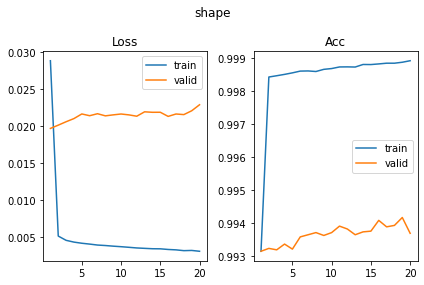

scale


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 126.72it/s, loss=0.999, acc=0.534]                                       
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 152.79it/s, loss=1.01, acc=0.572]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 124.95it/s, loss=0.925, acc=0.627]                                       
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 144.76it/s, loss=0.928, acc=0.576]                                         
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 124.50it/s, loss=0.865, acc=0.652]                                       
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 151.36it/s, loss=0.905, acc=0.599]                                         
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 132.96it/s, loss=0.854, acc=0.632]                                       
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 137.64it/s, loss=0.873, acc=0.612]  

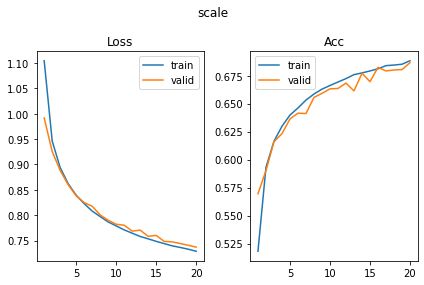

color


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 119.40it/s, loss=2.77, acc=0.0931]                                       
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 154.48it/s, loss=2.76, acc=0.0963]                                         
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 131.63it/s, loss=2.76, acc=0.098]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 152.44it/s, loss=2.76, acc=0.0744]                                         
Epoch [  3/ 20] train:██████████| 404/404 [00:02<00:00, 137.01it/s, loss=2.74, acc=0.113]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 112.39it/s, loss=2.76, acc=0.0744]                                         
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 123.93it/s, loss=2.73, acc=0.0735]                                       
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 147.76it/s, loss=2.76, acc=0.0659]  

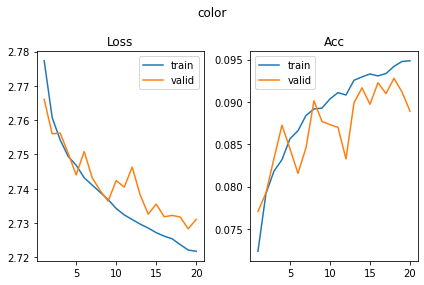

angle


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 123.20it/s, loss=2.47, acc=0.245]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 111.95it/s, loss=2.48, acc=0.226]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 107.79it/s, loss=2.35, acc=0.294]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 101.55it/s, loss=2.34, acc=0.294]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 110.43it/s, loss=2.18, acc=0.338]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 131.24it/s, loss=2.23, acc=0.313]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 109.31it/s, loss=2.2, acc=0.314]                                         
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 103.61it/s, loss=2.18, acc=0.306]   

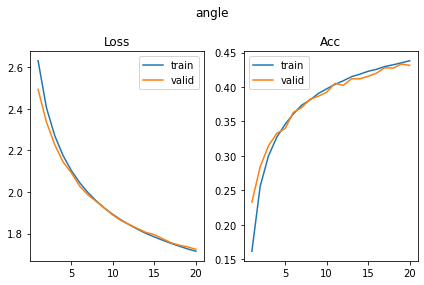

py


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 129.85it/s, loss=1.63, acc=0.377]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 105.65it/s, loss=1.6, acc=0.404]                                           
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 136.69it/s, loss=1.43, acc=0.485]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 123.19it/s, loss=1.42, acc=0.484]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 121.23it/s, loss=1.35, acc=0.495]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 149.29it/s, loss=1.3, acc=0.521]                                           
Epoch [  4/ 20] train:██████████| 404/404 [00:02<00:00, 137.11it/s, loss=1.23, acc=0.588]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 149.84it/s, loss=1.22, acc=0.559]   

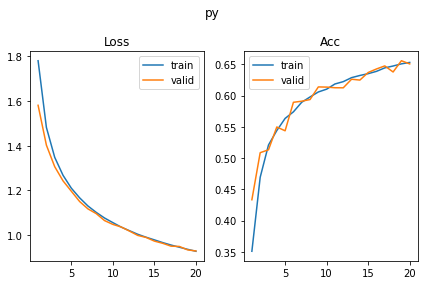

px


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 121.23it/s, loss=1.52, acc=0.48]                                         
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 135.22it/s, loss=1.5, acc=0.468]                                           
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 142.54it/s, loss=1.36, acc=0.475]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 134.42it/s, loss=1.34, acc=0.535]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 132.48it/s, loss=1.27, acc=0.549]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 149.16it/s, loss=1.23, acc=0.538]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 117.99it/s, loss=1.17, acc=0.574]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 131.90it/s, loss=1.17, acc=0.567]   

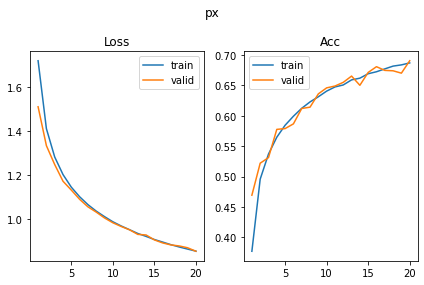

bb_[ResNet-18]_target_[scale]
shape


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 121.69it/s, loss=1.48, acc=0.417]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 150.75it/s, loss=1.43, acc=0.437]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 105.42it/s, loss=1.27, acc=0.505]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 123.02it/s, loss=1.33, acc=0.473]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 125.16it/s, loss=1.3, acc=0.495]                                         
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 135.06it/s, loss=1.31, acc=0.532]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 106.88it/s, loss=1.23, acc=0.505]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 141.17it/s, loss=1.26, acc=0.513]   

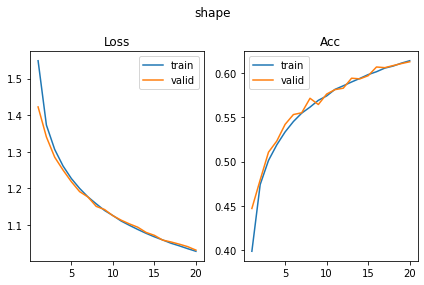

scale


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 124.83it/s, loss=0.0127, acc=0.995]                                      
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 144.07it/s, loss=0.0417, acc=0.98]                                         
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 119.35it/s, loss=0.0059, acc=1]                                          
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 152.71it/s, loss=0.0882, acc=0.973]                                        
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 128.93it/s, loss=0.00608, acc=1]                                         
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 146.77it/s, loss=0.049, acc=0.983]                                         
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 132.79it/s, loss=0.011, acc=0.995]                                       
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 151.85it/s, loss=0.0553, acc=0.985] 

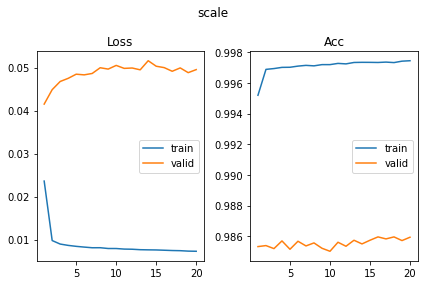

color


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 102.83it/s, loss=2.81, acc=0.0539]                                       
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 106.90it/s, loss=2.77, acc=0.0866]                                         
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 103.43it/s, loss=2.78, acc=0.0784]                                       
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 95.34it/s, loss=2.77, acc=0.0817]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 107.44it/s, loss=2.82, acc=0.0392]                                       
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 108.44it/s, loss=2.75, acc=0.089]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 101.62it/s, loss=2.75, acc=0.0931]                                       
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 105.27it/s, loss=2.77, acc=0.0732]  

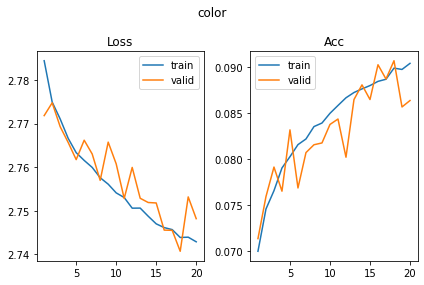

angle


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 104.81it/s, loss=2.76, acc=0.108]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 104.63it/s, loss=2.75, acc=0.102]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 102.07it/s, loss=2.75, acc=0.0784]                                       
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 95.84it/s, loss=2.75, acc=0.0768]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 103.55it/s, loss=2.74, acc=0.108]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 123.95it/s, loss=2.72, acc=0.105]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 115.91it/s, loss=2.74, acc=0.132]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 154.13it/s, loss=2.71, acc=0.127]   

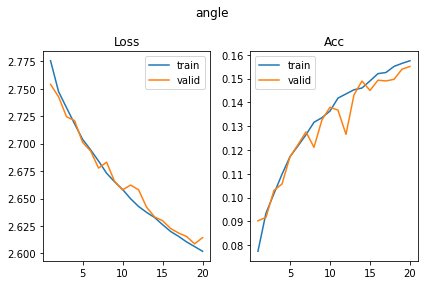

py


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 107.90it/s, loss=1.39, acc=0.515]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 92.45it/s, loss=1.39, acc=0.517]                                           
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 105.94it/s, loss=1.2, acc=0.529]                                         
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 107.18it/s, loss=1.22, acc=0.571]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 125.45it/s, loss=1.08, acc=0.667]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 150.71it/s, loss=1.14, acc=0.544]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 133.33it/s, loss=1.06, acc=0.623]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 120.72it/s, loss=1.07, acc=0.622]   

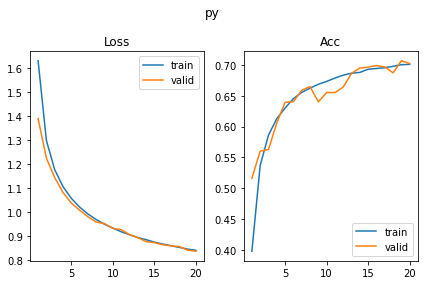

px


Epoch [  1/ 20] train:██████████| 404/404 [00:02<00:00, 140.10it/s, loss=1.32, acc=0.578]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 136.92it/s, loss=1.34, acc=0.506]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 125.18it/s, loss=1.2, acc=0.588]                                         
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 100.29it/s, loss=1.18, acc=0.589]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 126.04it/s, loss=1.05, acc=0.657]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 136.82it/s, loss=1.1, acc=0.616]                                           
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 117.76it/s, loss=1.06, acc=0.613]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 119.73it/s, loss=1.07, acc=0.616]   

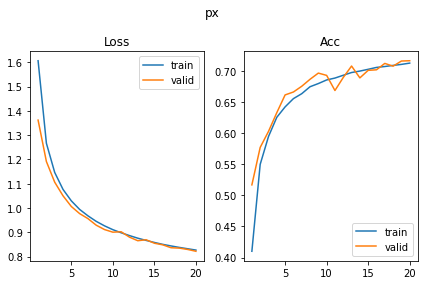

bb_[ResNet-18]_target_[color]
shape


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 109.79it/s, loss=1.9, acc=0.255]                                         
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 121.15it/s, loss=1.89, acc=0.239]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 137.18it/s, loss=1.83, acc=0.24]                                         
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 151.84it/s, loss=1.84, acc=0.235]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:02<00:00, 140.74it/s, loss=1.81, acc=0.206]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 153.33it/s, loss=1.84, acc=0.237]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:02<00:00, 141.17it/s, loss=1.81, acc=0.23]                                         
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 154.48it/s, loss=1.8, acc=0.24]     

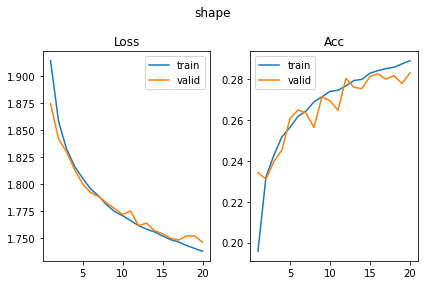

scale


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 132.20it/s, loss=1.36, acc=0.363]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 124.85it/s, loss=1.36, acc=0.324]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 141.93it/s, loss=1.33, acc=0.353]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 155.79it/s, loss=1.34, acc=0.365]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:02<00:00, 141.99it/s, loss=1.33, acc=0.368]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 154.84it/s, loss=1.33, acc=0.341]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:02<00:00, 141.95it/s, loss=1.3, acc=0.397]                                         
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 155.49it/s, loss=1.32, acc=0.337]   

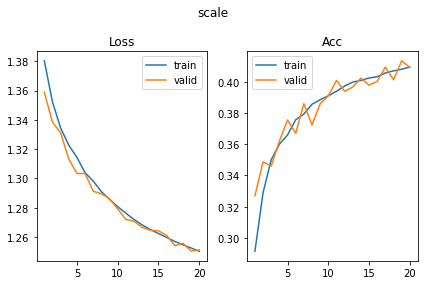

color


Epoch [  1/ 20] train:██████████| 404/404 [00:02<00:00, 139.90it/s, loss=0.00208, acc=1]                                         
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 152.58it/s, loss=0.00561, acc=0.999]                                       
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 142.16it/s, loss=0.00196, acc=1]                                         
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 139.42it/s, loss=0.00889, acc=0.998]                                       
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 133.62it/s, loss=0.000233, acc=1]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 116.78it/s, loss=0.00424, acc=0.999]                                       
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 133.67it/s, loss=0.00112, acc=1]                                         
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 152.61it/s, loss=0.00295, acc=0.999]

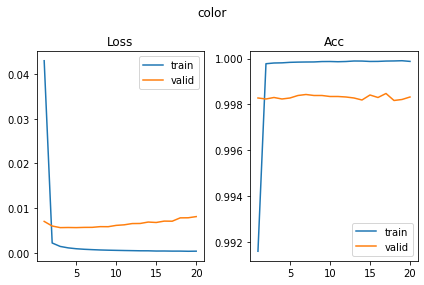

angle


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 133.70it/s, loss=2.78, acc=0.0686]                                       
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 138.87it/s, loss=2.81, acc=0.0573]                                         
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 141.45it/s, loss=2.79, acc=0.0735]                                       
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 135.74it/s, loss=2.78, acc=0.078]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:02<00:00, 143.43it/s, loss=2.79, acc=0.0539]                                       
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 151.56it/s, loss=2.78, acc=0.0695]                                         
Epoch [  4/ 20] train:██████████| 404/404 [00:02<00:00, 140.39it/s, loss=2.79, acc=0.0539]                                       
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 151.01it/s, loss=2.8, acc=0.0561]   

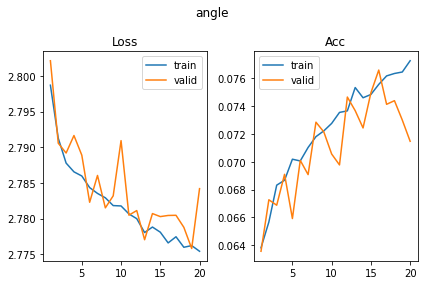

py


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 129.88it/s, loss=1.69, acc=0.436]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 135.29it/s, loss=1.75, acc=0.334]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 135.67it/s, loss=1.64, acc=0.392]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 113.30it/s, loss=1.58, acc=0.406]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:02<00:00, 138.06it/s, loss=1.49, acc=0.485]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 134.61it/s, loss=1.52, acc=0.413]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 132.82it/s, loss=1.44, acc=0.426]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 150.81it/s, loss=1.46, acc=0.427]   

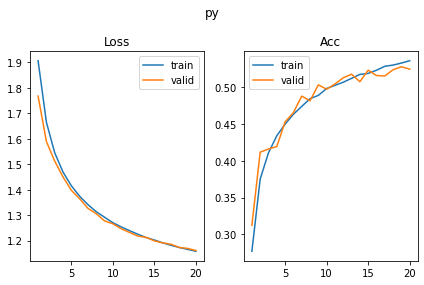

px


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 117.54it/s, loss=1.72, acc=0.387]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 134.87it/s, loss=1.75, acc=0.346]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 138.90it/s, loss=1.55, acc=0.348]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 134.42it/s, loss=1.57, acc=0.384]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:02<00:00, 139.24it/s, loss=1.45, acc=0.5]                                          
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 152.99it/s, loss=1.47, acc=0.44]                                           
Epoch [  4/ 20] train:██████████| 404/404 [00:02<00:00, 141.00it/s, loss=1.41, acc=0.495]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 151.62it/s, loss=1.35, acc=0.48]    

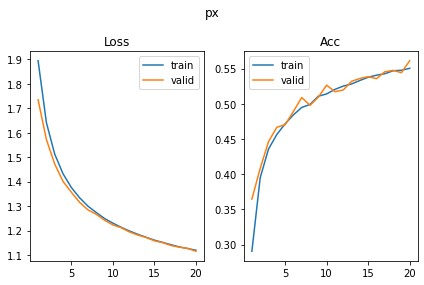

bb_[ResNet-18]_target_[angle]
shape


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 132.38it/s, loss=0.265, acc=0.961]                                       
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 151.17it/s, loss=0.295, acc=0.952]                                         
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 131.13it/s, loss=0.185, acc=0.951]                                       
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 144.06it/s, loss=0.177, acc=0.959]                                         
Epoch [  3/ 20] train:██████████| 404/404 [00:02<00:00, 139.14it/s, loss=0.148, acc=0.971]                                       
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 149.77it/s, loss=0.157, acc=0.965]                                         
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 129.46it/s, loss=0.133, acc=0.961]                                       
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 122.89it/s, loss=0.135, acc=0.96]   

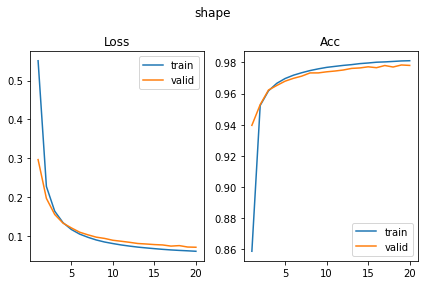

scale


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 129.86it/s, loss=1.26, acc=0.422]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 152.62it/s, loss=1.24, acc=0.474]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 123.44it/s, loss=1.15, acc=0.495]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 153.78it/s, loss=1.23, acc=0.459]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 124.63it/s, loss=1.16, acc=0.485]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 152.83it/s, loss=1.17, acc=0.489]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:02<00:00, 137.97it/s, loss=1.16, acc=0.456]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 151.02it/s, loss=1.14, acc=0.505]   

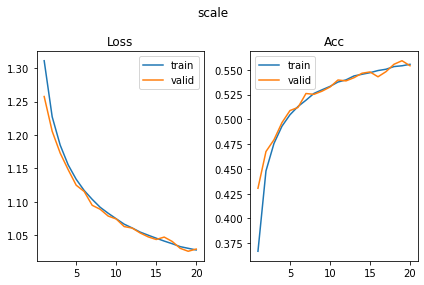

color


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 127.65it/s, loss=2.81, acc=0.0539]                                       
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 154.24it/s, loss=2.77, acc=0.0817]                                         
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 125.45it/s, loss=2.76, acc=0.0539]                                       
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 137.48it/s, loss=2.79, acc=0.089]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 129.16it/s, loss=2.77, acc=0.0539]                                       
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 155.02it/s, loss=2.77, acc=0.0793]                                         
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 134.55it/s, loss=2.76, acc=0.0833]                                       
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 147.97it/s, loss=2.78, acc=0.0805]  

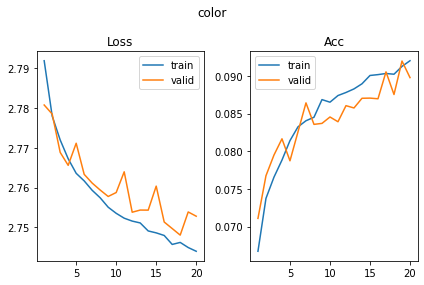

angle


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 126.61it/s, loss=0.606, acc=0.652]                                       
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 126.78it/s, loss=0.636, acc=0.659]                                         
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 135.30it/s, loss=0.6, acc=0.657]                                         
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 116.33it/s, loss=0.639, acc=0.623]                                         
Epoch [  3/ 20] train:██████████| 404/404 [00:02<00:00, 135.97it/s, loss=0.54, acc=0.711]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 141.91it/s, loss=0.624, acc=0.651]                                         
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 131.82it/s, loss=0.548, acc=0.711]                                       
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 152.44it/s, loss=0.614, acc=0.635]  

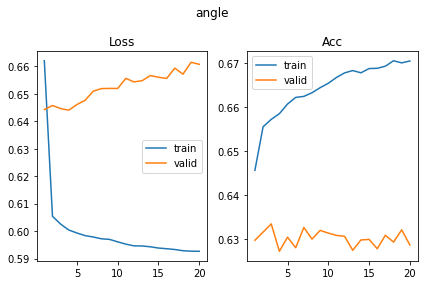

py


Epoch [  1/ 20] train:██████████| 404/404 [00:02<00:00, 142.03it/s, loss=1.81, acc=0.319]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 138.55it/s, loss=1.81, acc=0.31]                                           
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 145.25it/s, loss=1.67, acc=0.373]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 137.80it/s, loss=1.6, acc=0.457]                                           
Epoch [  3/ 20] train:██████████| 404/404 [00:02<00:00, 144.60it/s, loss=1.51, acc=0.451]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 151.46it/s, loss=1.52, acc=0.444]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:02<00:00, 142.45it/s, loss=1.45, acc=0.529]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 154.61it/s, loss=1.44, acc=0.488]   

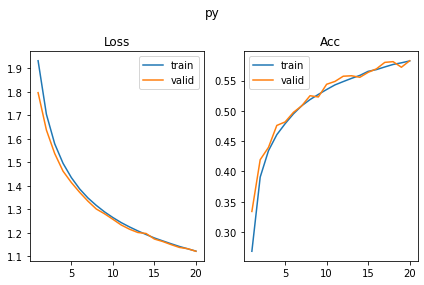

px


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 116.89it/s, loss=1.78, acc=0.343]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 115.16it/s, loss=1.78, acc=0.324]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 119.98it/s, loss=1.64, acc=0.402]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 105.88it/s, loss=1.66, acc=0.374]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 116.55it/s, loss=1.58, acc=0.363]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 109.29it/s, loss=1.52, acc=0.437]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 119.05it/s, loss=1.44, acc=0.515]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 139.31it/s, loss=1.48, acc=0.417]   

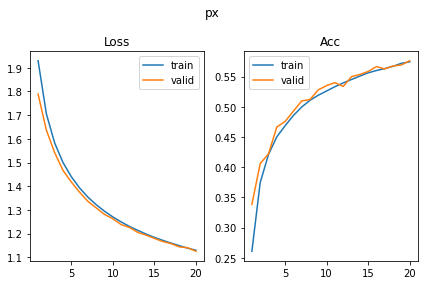

bb_[ResNet-18]_target_[py]
shape


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 132.33it/s, loss=1.49, acc=0.5]                                          
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 151.88it/s, loss=1.43, acc=0.52]                                           
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 133.34it/s, loss=1.29, acc=0.544]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 153.68it/s, loss=1.28, acc=0.568]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:02<00:00, 141.40it/s, loss=1.23, acc=0.529]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 152.89it/s, loss=1.22, acc=0.56]                                           
Epoch [  4/ 20] train:██████████| 404/404 [00:02<00:00, 140.37it/s, loss=1.18, acc=0.559]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 153.64it/s, loss=1.18, acc=0.574]   

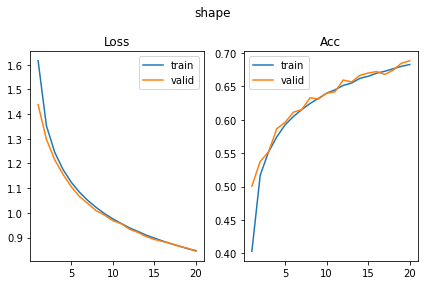

scale


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 132.00it/s, loss=1.22, acc=0.436]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 151.38it/s, loss=1.23, acc=0.427]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 139.59it/s, loss=1.19, acc=0.417]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 151.04it/s, loss=1.16, acc=0.477]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:02<00:00, 139.48it/s, loss=1.11, acc=0.515]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 151.11it/s, loss=1.16, acc=0.484]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:02<00:00, 139.60it/s, loss=1.07, acc=0.559]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 151.36it/s, loss=1.11, acc=0.506]   

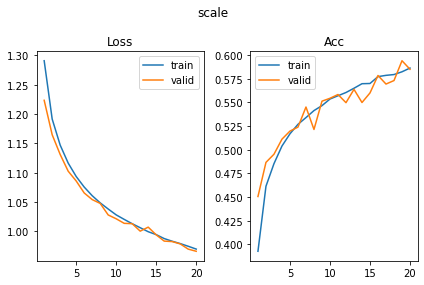

color


Epoch [  1/ 20] train:██████████| 404/404 [00:02<00:00, 141.86it/s, loss=2.79, acc=0.0539]                                       
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 151.63it/s, loss=2.78, acc=0.0744]                                         
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 140.81it/s, loss=2.8, acc=0.0637]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 138.11it/s, loss=2.78, acc=0.061]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:02<00:00, 143.01it/s, loss=2.79, acc=0.0637]                                       
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 154.15it/s, loss=2.77, acc=0.0732]                                         
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 121.42it/s, loss=2.76, acc=0.0833]                                       
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 109.02it/s, loss=2.78, acc=0.0793]  

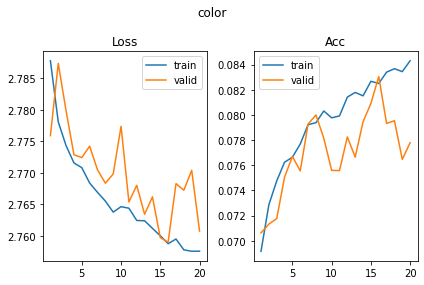

angle


Epoch [  1/ 20] train:██████████| 404/404 [00:02<00:00, 139.32it/s, loss=2.46, acc=0.181]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 135.33it/s, loss=2.54, acc=0.173]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 141.24it/s, loss=2.45, acc=0.147]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 135.43it/s, loss=2.4, acc=0.251]                                           
Epoch [  3/ 20] train:██████████| 404/404 [00:02<00:00, 141.49it/s, loss=2.42, acc=0.206]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 150.30it/s, loss=2.4, acc=0.22]                                            
Epoch [  4/ 20] train:██████████| 404/404 [00:02<00:00, 135.16it/s, loss=2.28, acc=0.27]                                         
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 154.18it/s, loss=2.3, acc=0.265]    

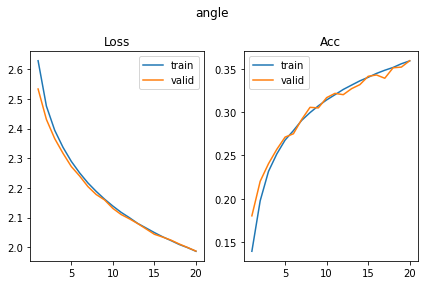

py


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 111.65it/s, loss=0.00311, acc=1]                                         
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 115.94it/s, loss=0.0177, acc=0.994]                                        
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 123.10it/s, loss=0.0025, acc=1]                                          
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 98.27it/s, loss=0.00881, acc=0.995]                                        
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 119.59it/s, loss=0.00054, acc=1]                                         
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 150.85it/s, loss=0.0224, acc=0.993]                                        
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 124.25it/s, loss=0.00479, acc=1]                                         
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 132.18it/s, loss=0.0059, acc=0.998] 

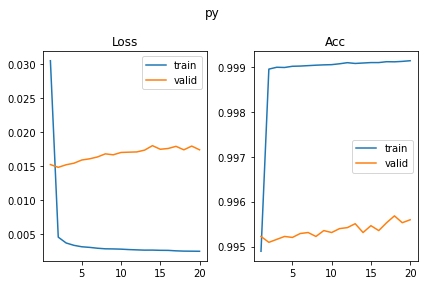

px


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 108.87it/s, loss=1.72, acc=0.353]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 127.13it/s, loss=1.69, acc=0.412]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 121.13it/s, loss=1.48, acc=0.49]                                         
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 131.42it/s, loss=1.49, acc=0.49]                                           
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 107.46it/s, loss=1.42, acc=0.461]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 112.97it/s, loss=1.4, acc=0.496]                                           
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 117.46it/s, loss=1.37, acc=0.466]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 130.51it/s, loss=1.34, acc=0.488]   

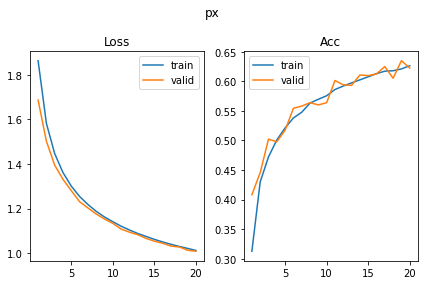

bb_[ResNet-18]_target_[px]
shape


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 127.23it/s, loss=1.46, acc=0.461]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 115.83it/s, loss=1.48, acc=0.462]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 131.03it/s, loss=1.36, acc=0.466]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 153.39it/s, loss=1.3, acc=0.512]                                           
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 129.06it/s, loss=1.16, acc=0.603]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 148.49it/s, loss=1.23, acc=0.549]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 125.16it/s, loss=1.16, acc=0.578]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 149.81it/s, loss=1.21, acc=0.529]   

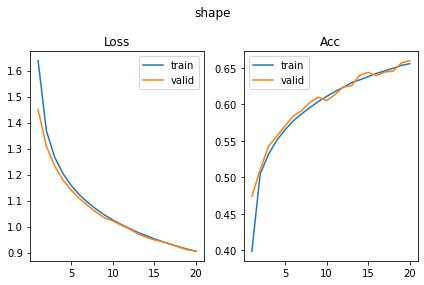

scale


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 132.23it/s, loss=1.25, acc=0.456]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 154.35it/s, loss=1.23, acc=0.409]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 124.43it/s, loss=1.22, acc=0.392]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 147.18it/s, loss=1.2, acc=0.461]                                           
Epoch [  3/ 20] train:██████████| 404/404 [00:02<00:00, 140.32it/s, loss=1.12, acc=0.49]                                         
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 151.45it/s, loss=1.16, acc=0.477]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:02<00:00, 139.71it/s, loss=1.14, acc=0.525]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 152.89it/s, loss=1.16, acc=0.457]   

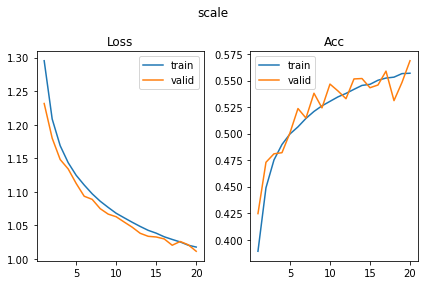

color


Epoch [  1/ 20] train:██████████| 404/404 [00:02<00:00, 139.24it/s, loss=2.76, acc=0.0735]                                       
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 150.40it/s, loss=2.78, acc=0.0927]                                         
Epoch [  2/ 20] train:██████████| 404/404 [00:03<00:00, 125.07it/s, loss=2.8, acc=0.049]                                         
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 101.14it/s, loss=2.79, acc=0.0524]                                         
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 119.58it/s, loss=2.8, acc=0.049]                                         
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 152.86it/s, loss=2.77, acc=0.0817]                                         
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 131.81it/s, loss=2.75, acc=0.113]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 152.96it/s, loss=2.79, acc=0.0598]  

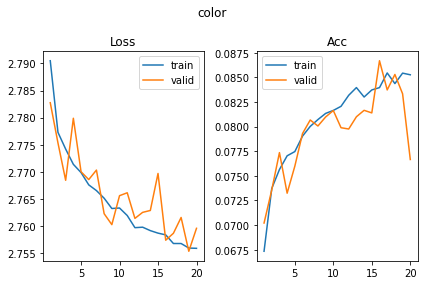

angle


Epoch [  1/ 20] train:██████████| 404/404 [00:02<00:00, 138.85it/s, loss=2.57, acc=0.162]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 133.76it/s, loss=2.57, acc=0.173]                                          
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 137.85it/s, loss=2.52, acc=0.191]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 135.11it/s, loss=2.5, acc=0.195]                                           
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 130.03it/s, loss=2.45, acc=0.186]                                        
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 141.85it/s, loss=2.45, acc=0.202]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:02<00:00, 137.65it/s, loss=2.39, acc=0.225]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 151.58it/s, loss=2.36, acc=0.245]   

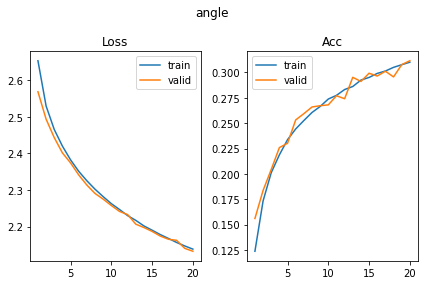

py


Epoch [  1/ 20] train:██████████| 404/404 [00:03<00:00, 126.17it/s, loss=1.67, acc=0.431]                                        
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 135.89it/s, loss=1.7, acc=0.412]                                           
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 141.06it/s, loss=1.55, acc=0.422]                                        
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 136.85it/s, loss=1.52, acc=0.449]                                          
Epoch [  3/ 20] train:██████████| 404/404 [00:03<00:00, 132.82it/s, loss=1.35, acc=0.51]                                         
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 149.04it/s, loss=1.42, acc=0.468]                                          
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 133.39it/s, loss=1.32, acc=0.471]                                        
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 127.05it/s, loss=1.33, acc=0.51]    

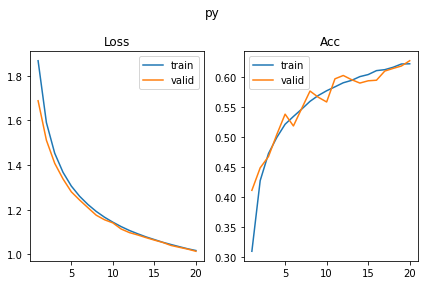

px


Epoch [  1/ 20] train:██████████| 404/404 [00:02<00:00, 138.83it/s, loss=0.00268, acc=1]                                         
Epoch [  1/ 20] valid:██████████| 45/45 [00:00<00:00, 131.63it/s, loss=0.0111, acc=0.996]                                        
Epoch [  2/ 20] train:██████████| 404/404 [00:02<00:00, 140.37it/s, loss=0.00572, acc=1]                                         
Epoch [  2/ 20] valid:██████████| 45/45 [00:00<00:00, 133.32it/s, loss=0.0246, acc=0.99]                                         
Epoch [  3/ 20] train:██████████| 404/404 [00:02<00:00, 138.54it/s, loss=0.00283, acc=1]                                         
Epoch [  3/ 20] valid:██████████| 45/45 [00:00<00:00, 111.08it/s, loss=0.0191, acc=0.991]                                        
Epoch [  4/ 20] train:██████████| 404/404 [00:03<00:00, 123.19it/s, loss=0.00176, acc=1]                                         
Epoch [  4/ 20] valid:██████████| 45/45 [00:00<00:00, 115.56it/s, loss=0.0155, acc=0.995] 

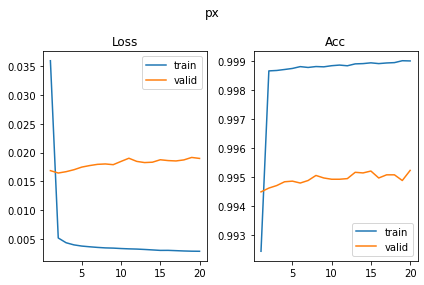

In [8]:
experiment_results = {}
for p_experiment in p_experiments:
    experiment_name = p_experiment.name
    print(experiment_name)
    #
    # experiment config
    p_experiment_config = p_experiment / "config.pkl"
    with open(p_experiment_config, "rb") as file:
        experiment_config = pickle.load(file)
    #
    # dataset config
    p_ds_config = Path(experiment_config.p_data) / "config.pkl"
    with open(p_ds_config, "rb") as file:
        ds_config = pickle.load(file)
    
    R_train = torch.Tensor(np.load(p_experiment / experiment_config["p_R_train"]))
    R_valid = torch.Tensor(np.load(p_experiment / experiment_config["p_R_valid"]))
    Y_train = torch.LongTensor(np.load(p_experiment / experiment_config["p_Y_train"]))
    Y_valid = torch.LongTensor(np.load(p_experiment / experiment_config["p_Y_valid"]))
    #
    results = {}
    for target_variable in ds_config["classes"]:
        print(target_variable)
        #
        target_idx = [idx for idx, target in enumerate(ds_config["classes"]) if target == target_variable][0]
        n_classes = ds_config["n_classes"][target_variable]
        #
        dl_train, dl_valid, d_r = get_datasets(target_idx)
        #
        model = Net(n_classes, d_r, linprob_config.d_hid, linprob_config.n_hid)
        model = model.to(device)
        #
        optimizer = get_optimizer(linprob_config.optimizer, model, linprob_config.optimizer_args)
        criterion = nn.CrossEntropyLoss()
        #
        stats = train_model(model, linprob_config.num_epochs, optimizer, criterion)
        results[target_variable] = stats

        # plot losses
        fig, axes = plt.subplots(1, 2)
        axes[0].plot(stats.train.epoch, stats.train.loss, label="train")
        axes[0].plot(stats.valid.epoch, stats.valid.loss, label="valid")
        #axes[0].set_yscale('log')
        axes[0].set_title("Loss")
        axes[0].legend()


        # plot accs
        axes[1].plot(stats.train.epoch, stats.train.acc, label="train")
        axes[1].plot(stats.valid.epoch, stats.valid.acc, label="valid")
        #axes[1].set_yscale('log')
        axes[1].set_title("Acc")
        axes[1].legend()
        #
        fig.suptitle(target_variable)
        plt.tight_layout()
        plt.show()
    p_results = p_experiment / linprob_config["p_results"]
    p_linprob_config = p_experiment / linprob_config["p_config"]
    #
    with open(p_results, "wb") as file:
        pickle.dump(results, file)
    with open(p_linprob_config, "wb") as file:
        pickle.dump(linprob_config, file)
    experiment_results[experiment_name] = results

In [9]:
p_eval =  Path(linprob_config["p_eval"])
p_results = p_eval / linprob_config["p_results"]
p_config = p_eval / linprob_config["p_config"]
p_plot = p_eval / "results.png"

In [10]:
with open(p_results, "wb") as file:
    pickle.dump(experiment_results, file)
with open(p_config, "wb") as file:
    pickle.dump(linprob_config, file)

In [11]:
n_avrg = 5
results = {}
model_names = list(experiment_results.keys())
target_variables = list(experiment_results[model_names[0]].keys())
all_accs = []
for model_name in model_names:
    model_accs = []
    for target_variable in target_variables:
        accs = experiment_results[model_name][target_variable]["valid"]['acc'][-n_avrg:]
        acc = sum(accs) / len(accs)
        model_accs.append(acc)
    all_accs.append(model_accs)
accs = np.array(all_accs)

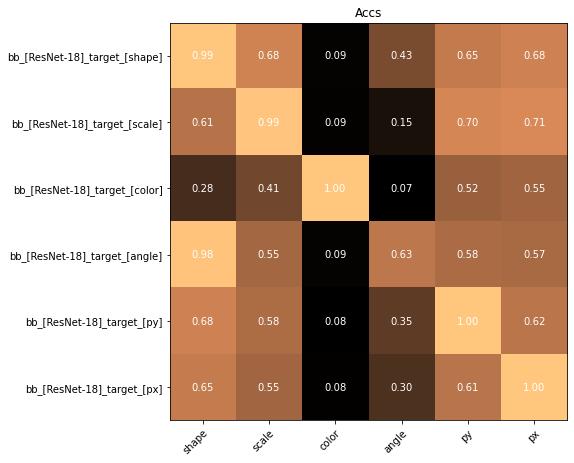

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(accs, cmap="copper")
#
ax.set_xticks(np.arange(len(target_variables)))
ax.set_yticks(np.arange(len(model_names)))
#
ax.set_xticklabels(target_variables)
ax.set_yticklabels(model_names)
#
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(target_variables)):
    for j in range(len(model_names)):
        text = ax.text(j, i, "{:.2f}".format(accs[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("Accs")
fig.tight_layout()
fig.savefig(p_plot)
plt.show()

In [13]:
# col means
print(accs.mean(axis=0))

[0.69803964 0.62614148 0.23826256 0.32239733 0.67539963 0.68646351]


In [14]:
# row means
print(accs.mean(axis=1))

[0.58664589 0.54055425 0.47140262 0.56572354 0.55020635 0.53217151]


In [15]:
accs.mean()

0.5411173598395673